In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow.keras as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import glob
import seaborn as sns
import json

In [2]:
# Set image size
s = 150
dataset = []
label = []

# Define directory paths
Diabetic_Foot_Ulcers = 'Diabetic Foot Ulcers'
Ordinary_wound = 'Ordinary wound'

# Function to decode and append images
def decode_and_append_images(directory, class_label):
    images = glob.glob(os.path.join(directory, '*'))
    for image in images:
        img = cv2.imread(image)
        if img is not None:  # Ensure image was successfully read
            img = cv2.resize(img, (s, s))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255.0  # Normalize to [0, 1]
            img = img.astype(np.float32)  # Cast to float32
            dataset.append(img)
            label.append(class_label)

# Decode images for DFU and Wound
decode_and_append_images(Diabetic_Foot_Ulcers, 0)
decode_and_append_images(Ordinary_wound, 1)

In [3]:
# Convert to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Display the shape of the dataset
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (1139, 150, 150, 3)
Label shape: (1139,)


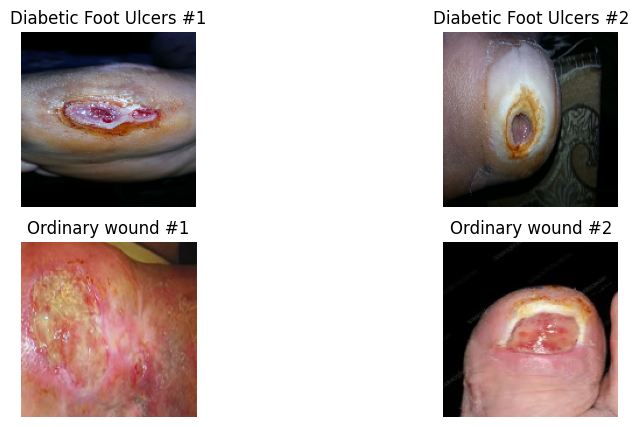

In [13]:
# Function to display sample images from the dataset
def display_samples(dataset, label, categories, num_samples=2):
    plt.figure(figsize=(10, 5))
    for i in range(len(categories)):
        category_indices = [index for index, lbl in enumerate(label) if lbl == i]
        for j in range(num_samples):
            plt.subplot(len(categories), num_samples, i * num_samples + j + 1)
            plt.imshow(dataset[category_indices[j]])
            plt.title(f"{categories[i]} #{j+1}")
            plt.axis('off')

    plt.show()

# Display 2 sample images from each category
display_samples(dataset, label, ['Diabetic Foot Ulcers', 'Ordinary wound'], num_samples=2)


In [4]:
# Shuffle the data
dataset, label = shuffle(dataset, label, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.25, stratify=label, random_state=43)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

In [5]:
# Build the model
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(s, s, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 32)      

In [6]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(X_train)

In [7]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop]
)

Epoch 1/30


27/27 [==============================] - 12s 361ms/step - loss: 0.9532 - accuracy: 0.6862 - val_loss: 0.3287 - val_accuracy: 0.8632
Epoch 2/30
27/27 [==============================] - 11s 407ms/step - loss: 0.3772 - accuracy: 0.8595 - val_loss: 0.3242 - val_accuracy: 0.8667
Epoch 3/30
27/27 [==============================] - 10s 378ms/step - loss: 0.3403 - accuracy: 0.8653 - val_loss: 0.5187 - val_accuracy: 0.8070
Epoch 4/30
27/27 [==============================] - 11s 408ms/step - loss: 0.3264 - accuracy: 0.8759 - val_loss: 0.3503 - val_accuracy: 0.8561
Epoch 5/30
27/27 [==============================] - 12s 433ms/step - loss: 0.2890 - accuracy: 0.8864 - val_loss: 0.4099 - val_accuracy: 0.8316
Epoch 6/30
27/27 [==============================] - 10s 382ms/step - loss: 0.2909 - accuracy: 0.8829 - val_loss: 0.3810 - val_accuracy: 0.8526
Epoch 7/30
27/27 [==============================] - 11s 389ms/step - loss: 0.3224 - accuracy: 0.8759 - val_loss: 0.5510 - val_accuracy: 0.75

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Use the class labels for evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

9/9 [==============================] - 0s 35ms/step - loss: 0.2326 - accuracy: 0.8982
Loss: 0.23255813121795654, Accuracy: 0.898245632648468
9/9 [==============================] - 0s 38ms/step
Accuracy: 0.8982456140350877
Precision: 0.9032597623089983
Recall: 0.8982456140350877
F1 Score: 0.8988756721525174


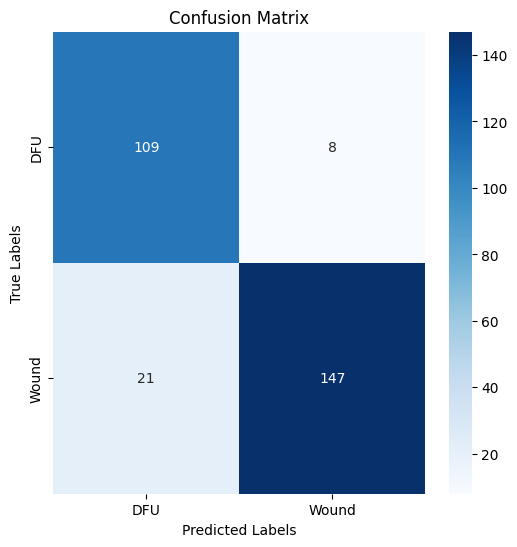

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['DFU', 'Wound'], yticklabels=['DFU', 'Wound'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

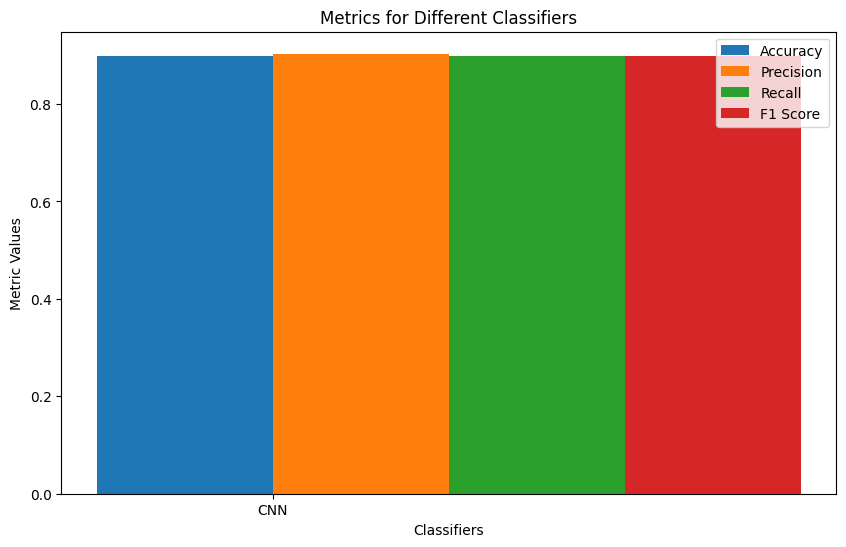

In [10]:
# Plotting Bar chart for metrics
classifiers= [ 'CNN']
metrics = [accuracy, precision, recall, f1]
bar_width = 0.2
index = np.arange(len(classifiers))

plt.figure(figsize=(10, 6))
plt.bar(index, metrics[0], bar_width, label='Accuracy')
plt.bar(index + bar_width, metrics[1], bar_width, label='Precision')
plt.bar(index + 2 * bar_width, metrics[2], bar_width, label='Recall')
plt.bar(index + 3 * bar_width, metrics[3], bar_width, label='F1 Score')

plt.xlabel('Classifiers')
plt.ylabel('Metric Values')
plt.title('Metrics for Different Classifiers')
plt.xticks(index +  bar_width / 2, classifiers)
plt.legend()
plt.show()


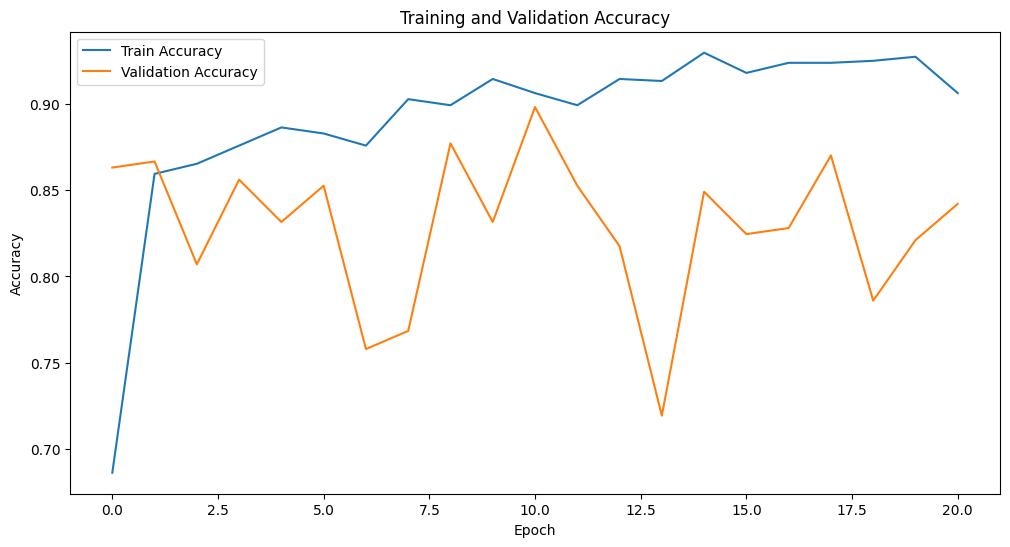

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [12]:
# Save the model as .h5 file
model.save('Diabetic_Foot_Ulcers.h5')
print("Model saved as 'Diabetic_Foot_Ulcers.h5'")

# Save the model architecture as JSON
model_json = model.to_json()
with open("Diabetic_Foot_Ulcers.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model architecture to 'Diabetic_Foot_Ulcers.json'")


F:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'Diabetic_Foot_Ulcers.h5'
Saved model architecture to 'Diabetic_Foot_Ulcers.json'
